<h1 align="center"><font size="5">Classification with Python</font></h1>

<h1 align="center"><font size="3">Matthys du Toit</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

The classification algorithms used in this notebook will aim to predict the loan status (paid/collection) of a random test data set as accurately as possible.

Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-09-27 17:17:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2021-09-27 17:17:36 (301 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



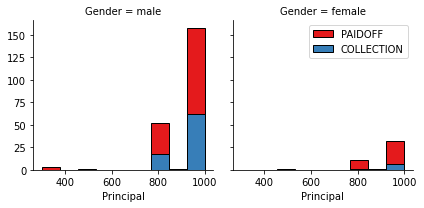

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

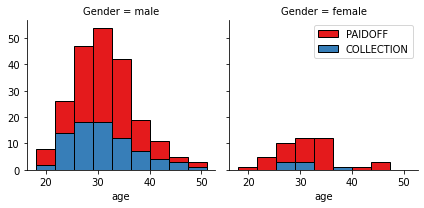

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


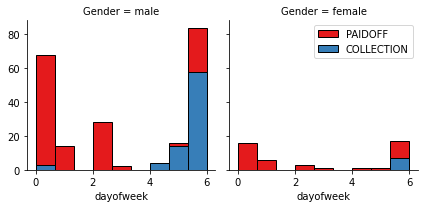

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

87 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Let's look at our loan status labels. 
<br>
Certain evaluation metrics to be used later will more easily quantify a model's accuracy with a set of integer predicted labels.

Let's convert the labelled data so that:

* 'PAIDOFF' loan status = 0 
* 'COLLECTION' loan status = 1

In [14]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [20]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# **Classification Model Training**


Now, we will use the training set to build an accurate model. Then use the test set to report the accuracy of the model
The following algorithm will be used:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


## K Nearest Neighbor (KNN)



### Train Test Split:

In order to achieve a high, out-of-sample accuracy model, the Train/Test evaluation approach is used.
This involves splitting the dataset into training and testing sets respectively, which are mutually exclusive.
<br>
Now train_test_split will return 4 different parameters, which we will name X_train, X_test, y_train and y_test.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)  
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Find the optimal K value to build the model with the best accuracy:

K in KNN is the number of nearest neighbours to examen in the model. The best value for K can be found by reserving a part of the data for testing the accuracy of the model, then incremently step through a defined range of K values where the predicted accuracy of each can be compared.

In [22]:
# set largest value of K to test
Ks = 10

# initialize the mean accuracy result array
mean_acc = np.zeros((Ks-1))
# initialize the standard deviation accuracy result array
std_acc = np.zeros((Ks-1))

# import library for classifier implementing the K-nearest neighbours vote
from sklearn.neighbors import KNeighborsClassifier
# import accuracy classification score function for computing subset accuarcy in multilabel classification
from sklearn import metrics 

# loop through each different K value
for K in range(1,Ks):
    
    # train model and predict
    neigh = KNeighborsClassifier(n_neighbors = K).fit(X_train,y_train)     # train
    yhat = neigh.predict(X_test)                                           # predict

    # test set accuracy evaluation 
    mean_acc[K-1] = metrics.accuracy_score(y_test,yhat)
    
    # standard deviation accuracy evaluation
    std_acc[K-1] = np.std(yhat == y_test)/np.sqrt(yhat.shape[0])
    
# display accuracy results for each value of K used in array
print("Test set Accuracy: ", mean_acc)


Test set Accuracy:  [0.67142857 0.77142857 0.71428571 0.77142857 0.75714286 0.78571429
 0.78571429 0.77142857 0.75714286]


Plot the model accuracy for range of K neighbour values:

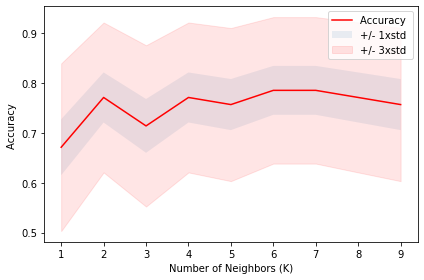

In [23]:
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="red")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Evaluation:

In [24]:
# display the best accuracy achieved by the model with the corresponding K value used

mean_acc_max = mean_acc.max()
mean_acc_max_3dp = "{:.3f}".format(mean_acc_max)

print( "The best accuracy was with", mean_acc_max_3dp, "(3 dp) with k =", mean_acc.argmax()+1) 

The best accuracy was with 0.786 (3 dp) with k = 6


## Decision Tree


Import Decision Tree Classifier function from scikit learn tree library:

In [25]:
# import required Decision Tree library
from sklearn.tree import DecisionTreeClassifier

The decision tree is set up using the training dataset provided; X and y.

### Modeling:

Create an instance of the DecisionTreeClassifier called loanStatusTree.
<br>
Within the classifier the criterion="entropy" has been specified to see the information gain of each node. 

In [26]:
# Loan Status Tree
loanStatusTree = DecisionTreeClassifier(criterion="entropy",max_depth = 10)
# show default parameters
loanStatusTree 

DecisionTreeClassifier(criterion='entropy', max_depth=10)

## Support Vector Machine


SVM works by mapping data to a high-dimensional feature space so that data points can be catagorized, even when the data are not otherwise linearly seperable. A seperator between the catagories is found, then the data is transformed in such a way that the seperator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new label should belong.

In [27]:
# Import required libraries
import pylab as pl
import scipy.optimize as opt

### Modeling:

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. We will use the default, RBF (Radial Basis Function) for this lab.

In [28]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')   # svm using radial basis function 

## Logistic Regression


Logistic Regression is a classification algorithm for catagorical variables. It is analogous to Linear Regression as it tries to predict a catagorical/discrete target field, instead of a numerical one.
<br>
The objective is to build a model to predict the class of each sample, in this case whether or not a loan will be paid off, as well as the probability of each sample belonging to a class.

### Modeling:

We will build our model using **LogisicRegression** from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters. 

The version of Logistic Regression in Scikit-learn, supports regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization.

The 'liblinear' solver is used as the algorithm in the optimization problem. It supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty.

Now let's fit our model with training dataset:

In [29]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear')
LR

LogisticRegression(C=0.01, solver='liblinear')

# Model Evaluation using Test set


When measuring the accuracy of the models, three different evaluation metrics for classifiers will be used. These include:

```
1. Jaccard Index
2. F1-score
3. Log Loss
```

The **Jaccard Index**, also known as 'Jaccard Score', is defined as the intersection divided by the size of the union of two label sets. It is used to compare the set of predicted labels for a sample to the corresponding set of labels in y_true.

The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 

**Log loss**, also known as logistic loss or cross-entropy loss, is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks. It is defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true.

In [30]:
# Import required evaluation metric libraries
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [31]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-09-27 17:17:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-09-27 17:17:56 (37.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation:


In [32]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [33]:
test_df.shape

(54, 10)

### Pre-processing of Test set:

Convert to date time object:

In [34]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
#test_df.head()

Use Feature Binarization to set a threshold value less than day 4:

In [35]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#test_df.head()

Convert catagorical features to numerical values:

In [36]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#test_df.head()

In [37]:
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
#test_df.head()

In [38]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
#test_Feature.head()

Feature selection:

Let's define features sets **X_TEST** and **y_TEST**

In [39]:
X_TEST = test_Feature
X_TEST[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [40]:
y_TEST = test_df['loan_status'].values
y_TEST[0:5]

array([0, 0, 0, 0, 0])

### KNN

The algorithm is run using the optimal K value previously computed as this will lead to the greatest accuracy in the model.

In [41]:
k = mean_acc.argmax()+1

# Fit the data with the test set feature matrix X_TEST and the training set response vector y_TEST:
neigh.fit(X_TEST,y_TEST)

# predict using model 'neigh' created from loan_train data
y_pred_KNN = neigh.predict(X_TEST)

# Evaluate the accuracy of the KNN model:

# Jaccard Index accuracy
j_1 = jaccard_score(y_TEST, y_pred_KNN, pos_label=0) 
print('KNN\'s accuracy using the Jaccard Index is',j_1)

# F1-score accuracy
f1_1 = f1_score(y_TEST, y_pred_KNN, pos_label=0)
print('KNN\'s accuracy using F1-score is',f1_1)

# Log Loss accuracy is not applicable to the KNN method as the predicted output is not a probability output between 0 and 1

KNN's accuracy using the Jaccard Index is 0.7346938775510204
KNN's accuracy using F1-score is 0.8470588235294118


### Decision Tree

In [42]:
# Fit the data with the test set feature matrix X_TEST and the training set response vector y_TEST:
loanStatusTree.fit(X_TEST,y_TEST)

# Predict on the testing dataset using the Loan Status Tree previously created from the training dataset
y_pred_Tree = loanStatusTree.predict(X_TEST)

# Evaluate the accuracy of the Decision Tree model:

# Jaccard Index accuracy
j_2 = jaccard_score(y_TEST, y_pred_Tree, pos_label=0)
print('Decision Tree\'s accuracy using the Jaccard Index is',j_2)

# F1-score accuracy
f1_2 = f1_score(y_TEST, y_pred_Tree, pos_label=0)
print('Decision Tree\'s accuracy using F1-score is',f1_2)

# Log Loss accuracy is not applicable to the KNN method as the predicted output is not a probability output between 0 and 1

Decision Tree's accuracy using the Jaccard Index is 0.9512195121951219
Decision Tree's accuracy using F1-score is 0.975


### SVM

In [43]:
# Fit the data with the test set feature matrix X_TEST and the training set response vector y_TEST:
clf.fit(X_TEST,y_TEST)

# Predict on the testing dataset using the previously trained SVM model
y_pred_SVM = clf.predict(X_TEST)

# Evaluate the accuracy of the SVM model:

# Jaccard Index accuracy
j_3 = jaccard_score(y_TEST, y_pred_SVM, pos_label=0)
print('SVM\'s accuracy using the Jaccard Index is',j_3)

# F1-score accuracy
f1_3 = f1_score(y_TEST, y_pred_SVM, pos_label=0)
print('SVM\'s accuracy using F1-score is',f1_3)

# Log Loss accuracy is not applicable to the KNN method as the predicted output is not a probability output between 0 and 1

SVM's accuracy using the Jaccard Index is 0.7407407407407407
SVM's accuracy using F1-score is 0.851063829787234


### Logistic Regression

**predict_proba**  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 'COLLECTION', P(Y=0|X), and second column is probability of class 'PAIDOFF', P(Y=1|X):


In [44]:
# Fit the data with the test set feature matrix X_TEST and the training set response vector y_TEST:
LR.fit(X_TEST,y_TEST)

# Predict on the testing dataset using the previously trained Logistic Regression model
y_pred_LogReg = LR.predict(X_TEST)
#print(y_pred_LogReg)

# Return estimates for the classes ordered by the label of the classes using predict_proba
y_pred_LogReg_prob = LR.predict_proba(X_TEST)
#print(y_pred_LogReg_prob[0:5])

# Evaluate the accuracy of the SVM model:

# Jaccard Index accuracy
j_4 = jaccard_score(y_TEST, y_pred_LogReg, pos_label=0)
print('Logistic Regression\'s accuracy using the Jaccard Index is',j_4)

# F1-score accuracy
f1_4 = f1_score(y_TEST, y_pred_LogReg, pos_label=0)
print('Logistic Regression\'s accuracy using F1-score is',f1_4)

# Log Loss accuracy...
ll_4 = log_loss(y_TEST, y_pred_LogReg_prob)
print('Logistic Regression\'s accuracy using Log Loss is',ll_4)

Logistic Regression's accuracy using the Jaccard Index is 0.7407407407407407
Logistic Regression's accuracy using F1-score is 0.851063829787234
Logistic Regression's accuracy using Log Loss is 0.5518728447980424


# Report

The table below presents a summary of the accuracy of the built models using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.735   | 0.847    | NA      |
| Decision Tree      | 0.952   | 0.976    | NA      |
| SVM                | 0.741   | 0.851    | NA      |
| LogisticRegression | 0.741   | 0.851    | 0.552   |
